In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

In [2]:
choice_order = ["gt", "mid", "lp"]
# Define fixed color palettes
time_limit_palette = {'1000.0': "#d6604d", '3000.0': "#f4a582"} 
choice_palette = {"gt": "#b2df8a", "mid": "#1f78b4", "lp": "#a6cee3"}  
response_palette = {"f": "#e08214", "j": "#8073ac"}

## Process Single Participant Data

In [3]:
def process_file(filename, canvas_width=1000):
    print(filename)
    # Add participant ID
    participant_ID = os.path.splitext(os.path.basename(filename))[0]
    df = pd.read_csv(filename)
    df['participant_ID'] = participant_ID

    # Select relevant columns
    selected_columns = [
        'subject_id', 'study_id', 'session_id', 'participant_ID', 
        'rt', 'response', 'task', 'ball_X', 'obstacle_groundTruth_x',
        'obstacle_groundTruth_y', 'stimulus_idx', 'trial_name', 'flipped',
        'choice', 'timeLimit', 'obstacle_choice_x', 'obstacle_choice_y', 'currentTrial'
    ]
    df = df[selected_columns]

    # Filter rows for specific tasks
    df = df[df['task'].isin(['ballFalling', 'yesOrNo'])]

    # Merge rows for 'ballFalling' and 'yesOrNo' tasks
    merged_df = df.groupby(['participant_ID', 'currentTrial'], as_index=False).first()

    # Sanity check
    print('----------Sanity Check---------')
    if merged_df.shape[0] != 144:
        print(f"For {participant_ID}, total rows: {merged_df.shape[0]}")
    if merged_df['stimulus_idx'].nunique() != 12 or merged_df['choice'].nunique() != 3 or len(merged_df['timeLimit'].unique()) != 2:
        print(f"ERROR IN DATA: {participant_ID}")
        print(f"Unique stimulus_idx: {merged_df['stimulus_idx'].nunique()}, choice: {merged_df['choice'].nunique()}, time limit: {merged_df['timeLimit'].unique()}")
    grouped = merged_df.groupby(['stimulus_idx', 'choice', 'timeLimit'])
    if not all(len(group) == 2 for _, group in grouped):
        print(f"ERROR IN DATA GROUPING: {participant_ID}")
    else:
        print('---------CLEAR---------')

    # Adjust flipped data
    merged_df['ball_X_final'] = merged_df['ball_X']
    merged_df['obstacle_groundTruth_x_final'] = merged_df['obstacle_groundTruth_x']
    merged_df['obstacle_choice_x_final'] = merged_df['obstacle_choice_x']

    merged_df.loc[merged_df['flipped'] == True, 'ball_X_final'] = canvas_width - merged_df['ball_X']
    merged_df.loc[merged_df['flipped'] == True, 'obstacle_groundTruth_x_final'] = canvas_width - merged_df['obstacle_groundTruth_x']
    merged_df.loc[merged_df['flipped'] == True, 'obstacle_choice_x_final'] = canvas_width - merged_df['obstacle_choice_x']

    # Handling missing data
    # Replace 'None' with NaN for missing data
    # merged_df
    merged_df['response'] = merged_df['response'].replace('None', pd.NA)
    merged_df['rt'] = merged_df['rt'].replace('None', pd.NA)

    # Accuracy calculation with explicit handling of null responses
    merged_df['is_accurate'] = merged_df.apply(
        lambda row: (
            ((row['response'] == 'j') and (row['choice'] == 'gt')) or
            ((row['response'] == 'f') and (row['choice'] in ['lp', 'mid']))
        ) if pd.notna(row['response']) else pd.NA,
        axis=1
    )

    # Explicitly cast to nullable boolean type
    merged_df['is_accurate'] = merged_df['is_accurate'].astype('boolean')

    # Enforce consistent order for 'choice'
    df['choice'] = pd.Categorical(df['choice'], categories=choice_order, ordered=True)
    return merged_df

# Example usage:
directory = 'rawData/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
print(f'Number of participants: {len(files)}.')

Number of participants: 6.


In [4]:
# print(files[-2])
# processed_data = process_file(files[-2])
# processed_data
# processed_data.groupby('timeLimit')['response'].value_counts() # good
# # number of j and f
# # Count the number of 'j' in the 'response' column
# j_count = processed_data['response'].value_counts().get('j', 0)
# f_count = processed_data['response'].value_counts().get('f', 0)
# print(j_count, f_count) # good

## Single Participant Data Summary

In [9]:
def analyze_data(df):
    # Calculate missing rate
    missing_rate_overall = df['response'].isna().mean()
    missing_rate_by_timeLimit = df.groupby('timeLimit')['response'].apply(lambda x: x.isna().mean())
    missing_rate_by_choice = df.groupby('choice')['response'].apply(lambda x: x.isna().mean())
    
    # RT analysis
    rt_overall = df['rt'].mean()
    rt_by_timeLimit = df.groupby('timeLimit')['rt'].mean()
    rt_by_choice = df.groupby('choice')['rt'].mean()

    # Split data by timeLimit
    rt_group_1 = df[df['timeLimit'] == 1000]['rt'].dropna()
    rt_group_2 = df[df['timeLimit'] == 3000]['rt'].dropna()

    # Perform independent t-test
    t_stat, p_value = ttest_ind(rt_group_1, rt_group_2, equal_var=False)  # Use Welch's t-test

    print(f"T-Test Results:")
    print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.3e}")
    if p_value < 0.05:
        print("Result: The difference in RTs between time limits is statistically significant.")
    else:
        print("Result: The difference in RTs between time limits is not statistically significant.")

    accuracy_overall = df['is_accurate'].mean()
    accuracy_by_timeLimit = df.groupby('timeLimit')['is_accurate'].mean()
    accuracy_by_choice = df.groupby('choice')['is_accurate'].mean()

    # Average RT for accurate/inaccurate responses
    avg_rt_accurate = df[df['is_accurate']]['rt'].mean()
    avg_rt_inaccurate = df[~df['is_accurate']]['rt'].mean()

    # Results summary
    summary = {
        'Missing Rate': {
            'Overall': missing_rate_overall,
            'By TimeLimit': missing_rate_by_timeLimit.to_dict(),
            'By Choice': missing_rate_by_choice.to_dict(),
        },
        'RT': {
            'Overall': rt_overall,
            'By TimeLimit': rt_by_timeLimit.to_dict(),
            'By Choice': rt_by_choice.to_dict(),
        },
        'Accuracy': {
            'Overall': accuracy_overall,
            'By TimeLimit': accuracy_by_timeLimit.to_dict(),
            'By Choice': accuracy_by_choice.to_dict()
        },
        'Average RT for Accuracy': {
            'Accurate': avg_rt_accurate,
            'Inaccurate': avg_rt_inaccurate,
        }
    }

    # Print the summary in a readable format
    print("\nAnalysis Summary:")
    pprint(summary, width=100, sort_dicts=False)
    
    # Visualizations
    plot_data(df)
    
    return summary

def get_confusionMatrix(df):
    # Remove rows with null responses
    df = df.dropna(subset=['response'])

    # Define actual labels (positive for 'gt', negative for 'lp' or 'mid')
    df['actual'] = df['choice'].apply(lambda x: 'positive' if x == 'gt' else 'negative')

    # Define predicted labels (positive for 'j', negative for 'f')
    df['predicted'] = df['response'].apply(lambda x: 'positive' if x == 'j' else 'negative')

    # Generate confusion matrix
    cm = confusion_matrix(df['actual'], df['predicted'], labels=['positive', 'negative'])

    # Display confusion matrix
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Positive', 'Negative'])
    cmd.plot(cmap='Blues')
    cmd.ax_.set_title("Confusion Matrix")
    cmd.ax_.set_xlabel("Participant Responses")
    cmd.ax_.set_ylabel("Actual Labels")

    # Disable grid lines
    cmd.ax_.grid(False)
    
    plt.show()

    # cm by time limit and choice
    for time_limit in df['timeLimit'].unique():
        subset = df[df['timeLimit'] == time_limit]
        cm_by_tl = confusion_matrix(subset['actual'], subset['predicted'], labels=['positive', 'negative'])
        print(f"Confusion Matrix for timeLimit = {time_limit}")
        print(cm_by_tl)
    
    for choice in df['choice'].unique():
        subset = df[df['choice'] == choice]
        cm_by_choice = confusion_matrix(subset['actual'], subset['predicted'], labels=['positive', 'negative'])
        print(f"Confusion Matrix for timeLimit = {choice}")
        print(cm_by_choice)
    return cm

# Functions to calculate metrics
def calculate_metrics(cm):
    # Confusion matrix values
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    }

def plot_data(df):
    """
    Generate visualizations for missing rate, RT, and accuracy with improved aesthetics.
    Group related plots into subplots.
    """
    sns.set_theme(style="whitegrid", context="talk")  # Use a scientific theme

    # Prepare data
    missing_rate_by_timeLimit = df.groupby('timeLimit')['response'].apply(lambda x: x.isna().mean()).reset_index()
    missing_rate_by_choice = df.groupby('choice')['response'].apply(lambda x: x.isna().mean()).reset_index()
    accuracy_by_timeLimit = df.groupby('timeLimit')['is_accurate'].mean().reset_index()
    accuracy_by_choice = df.groupby('choice')['is_accurate'].mean().reset_index()
    
    # Initialize the figure
    fig, axs = plt.subplots(3, 2, figsize=(8, 10), constrained_layout=True)
    fig.suptitle("Data Analysis Summary", fontsize=20, y=1.02)

    # Plot Missing Rate
    sns.barplot(data=missing_rate_by_timeLimit, x='timeLimit', y='response', ax=axs[0, 0], palette=time_limit_palette, width=0.6)
    axs[0, 0].set_title('Missing Rate by TimeLimit')
    axs[0, 0].set_xlabel('Time Limit')
    axs[0, 0].set_ylabel('Missing Rate')
    axs[0, 0].set_ylim(0, 1)

    sns.barplot(data=missing_rate_by_choice, x='choice', y='response', ax=axs[0, 1], palette=choice_palette, order=choice_order, width=0.6)
    axs[0, 1].set_title('Missing Rate by Choice')
    axs[0, 1].set_xlabel('Choice')
    axs[0, 1].set_ylabel('Missing Rate')
    axs[0, 1].set_ylim(0, 1)

    # Plot Reaction Times with Violin Plot
    sns.violinplot(data=df, x='timeLimit', y='rt', ax=axs[1, 0], palette=time_limit_palette, inner='box', scale='width')
    axs[1, 0].set_title('Reaction Time (RT) by TimeLimit')
    axs[1, 0].set_xlabel('Time Limit')
    axs[1, 0].set_ylabel('RT')

    for violin in axs[1, 0].collections:
        violin.set_edgecolor(None)

    sns.violinplot(data=df, x='choice', y='rt', ax=axs[1, 1], palette=choice_palette, order=choice_order, inner='box', scale='width')
    axs[1, 1].set_title('Reaction Time (RT) by Choice')
    axs[1, 1].set_xlabel('Choice')
    axs[1, 1].set_ylabel('RT')

    for violin in axs[1, 1].collections:
        violin.set_edgecolor(None)

    # Plot Accuracy
    sns.barplot(data=accuracy_by_timeLimit, x='timeLimit', y='is_accurate', ax=axs[2, 0], palette=time_limit_palette, width=0.6)
    axs[2, 0].set_title('Accuracy by TimeLimit')
    axs[2, 0].set_xlabel('Time Limit')
    axs[2, 0].set_ylabel('Accuracy')
    axs[2, 0].set_ylim(0, 1)

    sns.barplot(data=accuracy_by_choice, x='choice', y='is_accurate', ax=axs[2, 1], palette=choice_palette, order=choice_order, width=0.6)
    axs[2, 1].axhline(y=0.5, linewidth=2, color='black', ls=':')
    axs[2, 1].set_title('Accuracy by Choice')
    axs[2, 1].set_xlabel('Choice')
    axs[2, 1].set_ylabel('Accuracy')
    axs[2, 1].set_ylim(0, 1)

    # Show the plot
    plt.show()

In [10]:
# Create the stacked count plot
def plot_stacked_freq(data):
    sns.set_theme(style="whitegrid", context="talk")  # Set a scientific theme for aesthetics

    data = data.dropna(subset=['response'])

    # Create subplots for each time limit
    time_limits = data['timeLimit'].unique()
    fig, axs = plt.subplots(1, len(time_limits), figsize=(9, 6), sharey=True, constrained_layout=True)

    for i, time_limit in enumerate(sorted(time_limits)):
        ax = axs[i] if len(time_limits) > 1 else axs  # Handle single subplot case
        subset = data[data['timeLimit'] == time_limit]

        # If ploting percentage instead of counts
        # Calculate percentages
        subset['weight'] = subset.groupby('choice')['response'].transform('count')  # Total counts per choice
        subset['weight'] = 100 / subset['weight']  # Normalize to percentages
        
        # Plot a stacked bar chart
        sns.histplot(
            data=subset,
            x="choice",
            hue="response",
            weights="weight", # Use the normalized percentages
            multiple="stack",
            shrink=0.8,
            ax=ax,
            palette=response_palette,
            hue_order=['f', 'j']  # Ensure consistent hue order
        )
        ax.set_title(f"Time Limit: {time_limit}")
        ax.set_xlabel("Choice")
        # ax.set_ylabel("Count" if i == 0 else "")
        ax.axhline(y=50, linewidth=3, color="black", ls=':')
        ax.set_ylabel("Percentage" if i == 0 else "")
        ax.set_ylim(0, 110)  # Set y-axis to 0-100 for percentages

    # Add a global title
    # plt.suptitle("Stacked Count of Responses ('f' and 'j') by Time Limit and Choice", fontsize=16)
    plt.suptitle("Stacked Percentage of Responses ('f' and 'j') by Time Limit and Choice", fontsize=16)
    plt.show()

In [ ]:
# Example usage:
directory = 'rawData/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
file = files[5]
df = process_file(file)
print('----------Data Quality Check---------')
summary = analyze_data(df)
print('---------CLEAR---------')
cm = get_confusionMatrix(df)
cm_metric = calculate_metrics(cm)
pprint(cm_metric)
plot_stacked_freq(df)

## All Participants Data

In [ ]:
# Process each file
directory = 'rawData/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
dfs = []
for file in files:   
    df = process_file(file)
    print('----------Data Quality Check---------')
    summary = analyze_data(df)
    print('---------CLEAR---------')
    cm = get_confusionMatrix(df)
    cm_metric = calculate_metrics(cm)
    pprint(cm_metric)
    plot_stacked_freq(df)
    if file != 'rawData/67884b1aa6c55d9dd2388778_result.csv':
        dfs.append(df)
        print('Attaching new participant data...')

# Merge all dataframes
df_all = pd.concat(dfs, ignore_index=True)
df_all['choice'] = pd.Categorical(df_all['choice'], categories=choice_order, ordered=True)

## flip rate
flipRate = df_all['flipped'].mean()
print(f'Flip Rate: {flipRate}')

T-Test Results:
T-Statistic: -4.979, P-Value: 8.224e-07
Result: The difference in RTs between time limits is statistically significant.

Analysis Summary:
{'Missing Rate': {'Overall': 0.04027777777777778,
                  'By TimeLimit': {1000.0: 0.07777777777777778, 3000.0: 0.002777777777777778},
                  'By Choice': {'gt': 0.03333333333333333,
                                'mid': 0.041666666666666664,
                                'lp': 0.04583333333333333}},
 'RT': {'Overall': 596.7149059334298,
        'By TimeLimit': {1000.0: 545.9307228915662, 3000.0: 643.6796657381616},
        'By Choice': {'gt': 597.0431034482758, 'mid': 600.7391304347826, 'lp': 592.3406113537118}},
 'Accuracy': {'Overall': 0.44283646888567296,
              'By TimeLimit': {1000.0: 0.41566265060240964, 3000.0: 0.467966573816156},
              'By Choice': {'gt': 0.6982758620689655,
                            'mid': 0.29130434782608694,
                            'lp': 0.33624454148471616}},


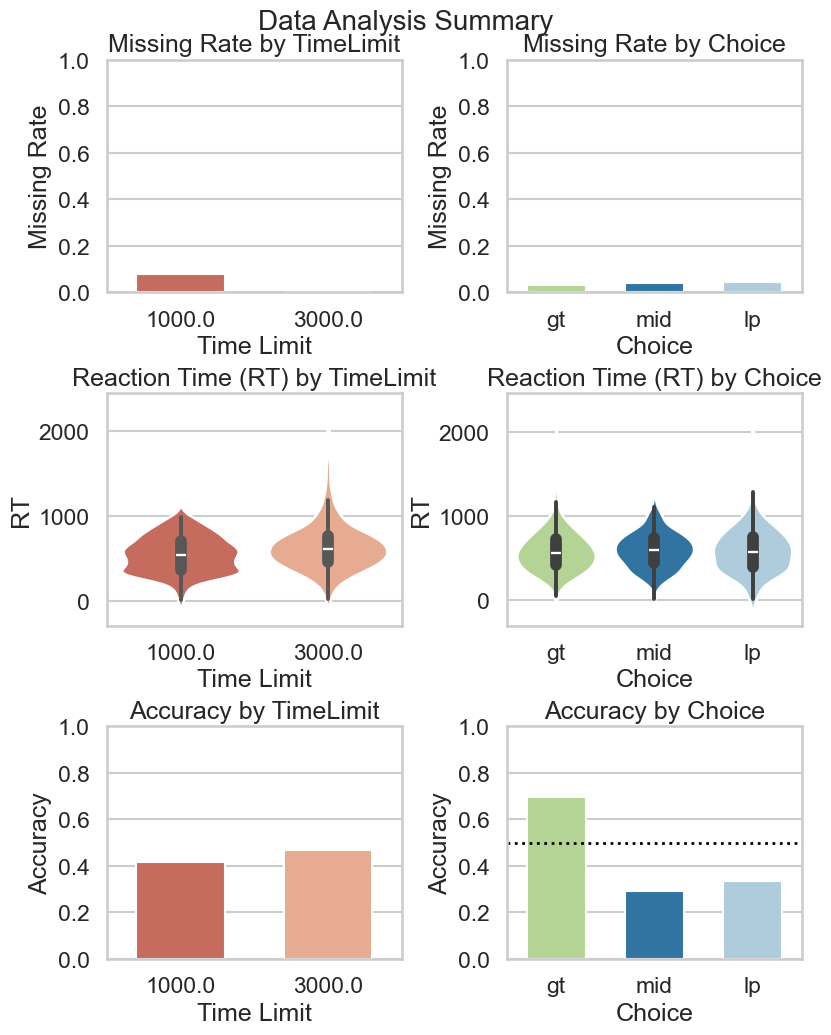

---------CLEAR---------


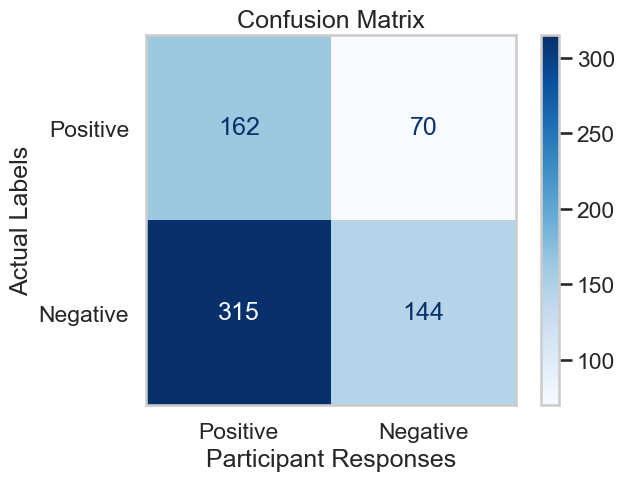

Confusion Matrix for timeLimit = 1000.0
[[ 80  32]
 [162  58]]
Confusion Matrix for timeLimit = 3000.0
[[ 82  38]
 [153  86]]
Confusion Matrix for timeLimit = lp
[[  0   0]
 [152  77]]
Confusion Matrix for timeLimit = mid
[[  0   0]
 [163  67]]
Confusion Matrix for timeLimit = gt
[[162  70]
 [  0   0]]
{'Accuracy': 0.44283646888567296,
 'F1 Score': 0.4279346210995542,
 'False Negatives': 315,
 'False Positives': 70,
 'Precision': 0.6728971962616822,
 'Recall': 0.3137254901960784,
 'True Negatives': 162,
 'True Positives': 144}


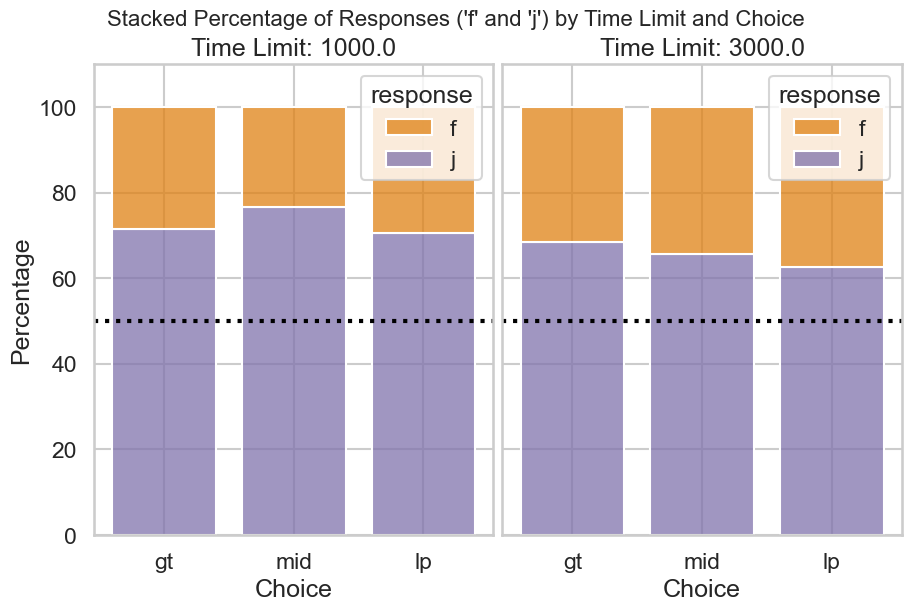

In [14]:
df_all
df_all.to_csv('df_all_pilot_v0_5participants.csv', index=False)
summary_all = analyze_data(df_all)
print('---------CLEAR---------')
cm_all = get_confusionMatrix(df_all)
cm_metric_all = calculate_metrics(cm_all)
pprint(cm_metric_all)
# drops na after calculating missing rates
df_all = df_all.dropna(subset=['response'])
plot_stacked_freq(df_all)

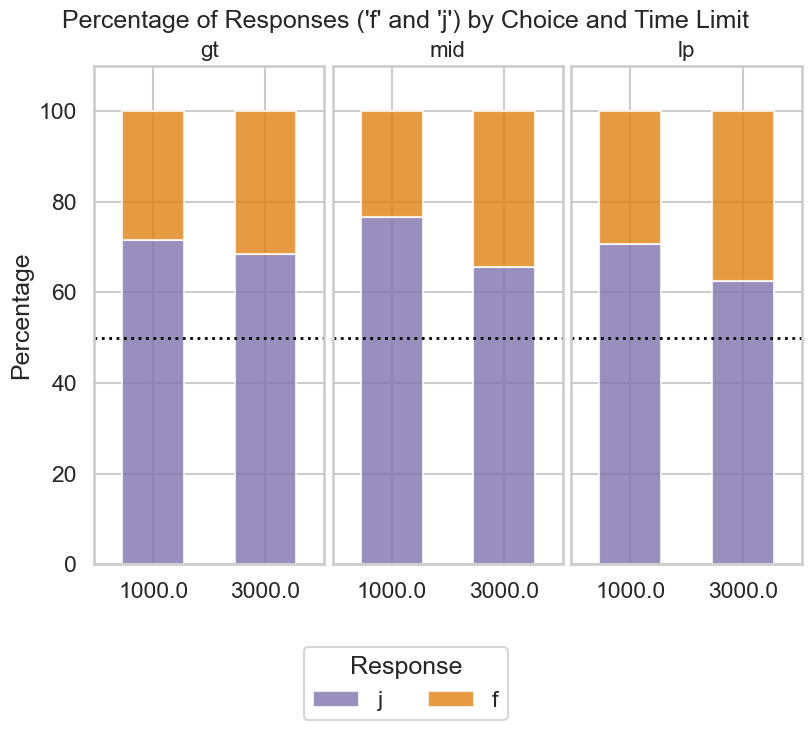

In [41]:
# Create stacked bar plot with grouped x-axis
def plot_grouped_stacked_bar(data):
    sns.set_theme(style="whitegrid", context="talk")  # Use a clean theme

    # Drop missing responses
    data = data.dropna(subset=['response'])

    # Prepare data for grouped stacked bar plot
    grouped_data = (
        data.groupby(['choice', 'timeLimit', 'response'])
        .size()
        .reset_index(name='count')  # Count occurrences
    )

    # Calculate percentages
    grouped_data['total'] = grouped_data.groupby(['choice', 'timeLimit'])['count'].transform('sum')
    grouped_data['percentage'] = 100 * grouped_data['count'] / grouped_data['total']

    # Create subplots for each choice
    choices = sorted(data['choice'].unique())
    fig, axs = plt.subplots(1, len(choices), figsize=(8, 6), sharey=True, constrained_layout=True)

    for i, choice in enumerate(choice_order):
        ax = axs[i] if len(choices) > 1 else axs  # Handle single subplot case
        subset = grouped_data[grouped_data['choice'] == choice]

        # Pivot the data for stacking
        pivot_data = subset.pivot(index='timeLimit', columns='response', values='percentage').fillna(0)

        # Reorder columns to ensure `j` is at the bottom
        pivot_data = pivot_data[['j', 'f']]  # Ensure `j` comes before `f`

        # Plot stacked bars
        pivot_data.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[response_palette['j'], response_palette['f']],
            legend=False,
            alpha=0.8,
            width=0.55
        )
        ax.set_title(f"{choice}", fontsize=16)
        ax.set_xlabel("")
        ax.set_ylabel("Percentage" if i == 0 else "", fontsize=18)
        ax.set_ylim(0, 110)  # Set y-axis to 0-100 for percentages
        ax.axhline(y=50, linewidth=2, color="black", ls=":")

        # Rotate x-axis labels to horizontal
        ax.tick_params(axis='x', labelrotation=0)

    # Add a global title
    plt.suptitle("Percentage of Responses ('f' and 'j') by Choice and Time Limit", fontsize=18)
    # Add legend for the last subplot
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Response", loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.show()

# Use the updated function
plot_grouped_stacked_bar(df_all)

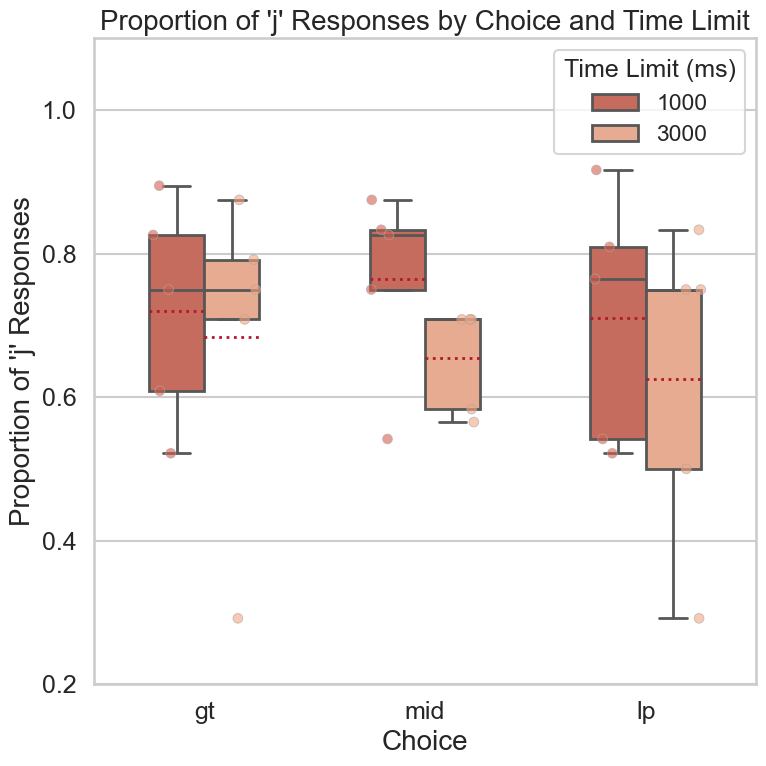

In [47]:
# Refined Plot: Proportion of 'j' Responses with Scatter Overlay
def plot_response_distribution_refined(data):
    sns.set_theme(style="whitegrid", context="talk")  # Use a clean theme

    # Calculate proportion of 'j' responses by participant, timeLimit, and choice
    response_j_by_participant = (
        data.assign(is_j=data['response'] == 'j')  # Create a boolean column for 'j' responses
        .groupby(['subject_id', 'timeLimit', 'choice'])['is_j']
        .mean()
        .reset_index()
    )

    # Create the figure
    plt.figure(figsize=(8, 8), constrained_layout=True)

    # Box plot for proportions with narrower boxes
    box = sns.boxplot(
        data=response_j_by_participant,
        x='choice',
        y='is_j',
        hue='timeLimit',
        palette={1000.0: "#d6604d", 3000.0: "#f4a582"},
        order=choice_order,
        dodge=True,
        width=0.5,  # Narrower boxes
        showmeans=True,  # Add mean line
        meanline=True,  # Use a line for the mean
        meanprops={"color": "#b2182b", "ls": ":", "lw": 2},  # Style for mean line
        linewidth=2,  # Outline points
        fliersize=0  # Hide default outliers
    )

    # Add scatter points for individual data points
    scatter = sns.stripplot(
        data=response_j_by_participant,
        x='choice',
        y='is_j',
        hue='timeLimit',
        palette={1000.0: "#d6604d", 3000.0: "#f4a582"},
        order=choice_order,
        dodge=True,
        alpha=0.6,  # Transparency for overlapping points
        size=7,  # Adjust point size
        linewidth=0.7,  # Outline points
        edgecolor="darkgray"
    )

    # Refine the legend to avoid duplication
    handles, labels = box.get_legend_handles_labels()
    plt.legend(handles[:2], ['1000', '3000'], title="Time Limit (ms)")

    # Customize title and labels
    plt.title("Proportion of 'j' Responses by Choice and Time Limit", fontsize=20)
    plt.xlabel("Choice", fontsize=20)
    plt.ylabel("Proportion of 'j' Responses", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(0.2, 1.1)

    # Tight layout for better appearance
    plt.tight_layout()
    plt.show()

# Use the refined function
plot_response_distribution_refined(df_all)

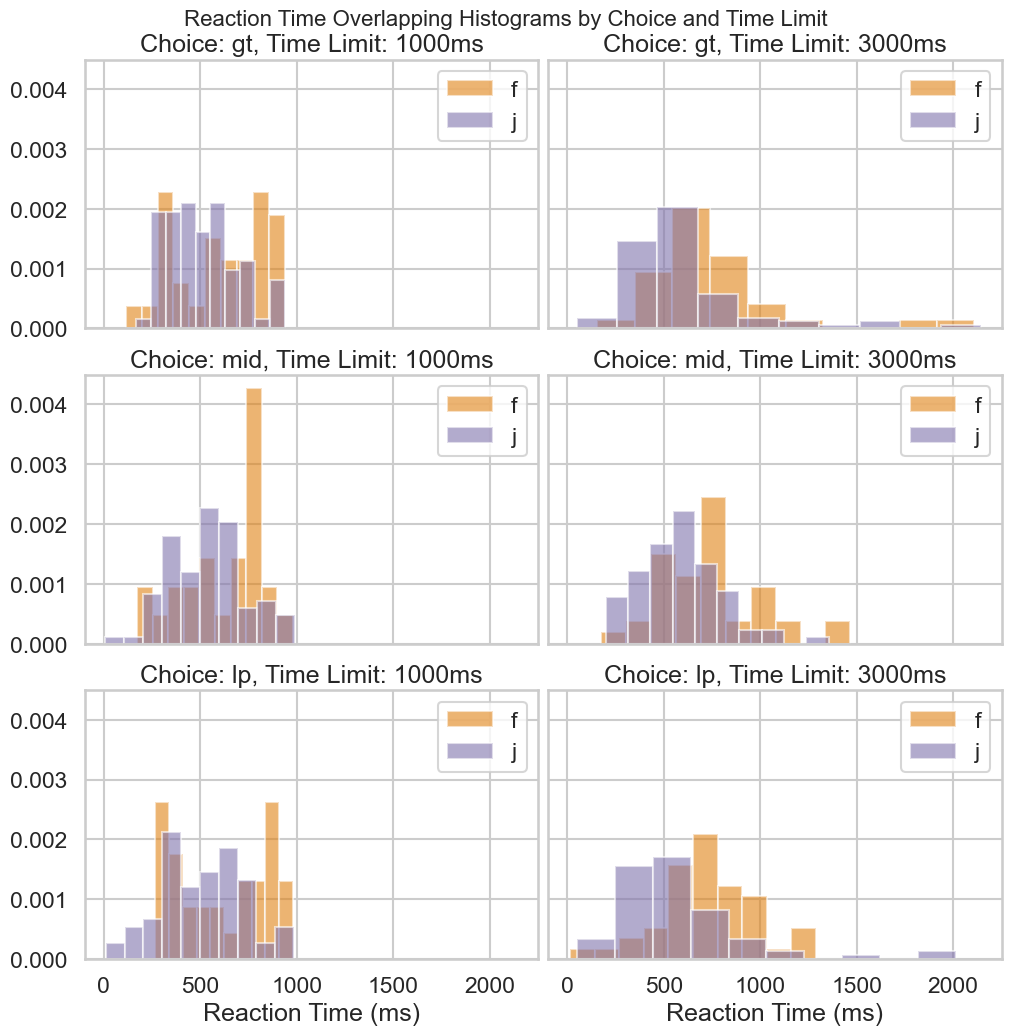

In [52]:
# Refined overlapping distribution plot using histograms
def plot_rt_histogram_grid(data):
    sns.set_theme(style="whitegrid", context="talk")

    # Create a 2x3 grid of subplots with shared x and y axes
    choices = ['gt', 'mid', 'lp']
    time_limits = [1000, 3000]
    fig, axs = plt.subplots(3, 2, figsize=(10, 10), constrained_layout=True, sharex=True, sharey=True)
    
    # Iterate through choices and time limits to populate the grid
    for i, choice in enumerate(choices):
        for j, time_limit in enumerate(time_limits):
            ax = axs[i, j]
            subset = data[(data['choice'] == choice) & (data['timeLimit'] == time_limit)]
            
            # Plot overlapping histograms for responses 'f' and 'j'
            if not subset.empty:
                subset_f = subset[subset['response'] == 'f']
                subset_j = subset[subset['response'] == 'j']
                ax.hist(
                    subset_f['rt'], bins=10, alpha=0.6, color=response_palette['f'], label='f', density=True
                )
                ax.hist(
                    subset_j['rt'], bins=10, alpha=0.6, color=response_palette['j'], label='j', density=True
                )
            ax.set_title(f"Choice: {choice}, Time Limit: {time_limit}ms")
            ax.set_xlabel("Reaction Time (ms)" if i == 2 else "")
            # ax.set_ylabel("Density" if j == 0 else "")
            ax.legend(loc='upper right')

    # Add a global title
    fig.suptitle("Reaction Time Overlapping Histograms by Choice and Time Limit", fontsize=16, y=1.02)
    plt.show()

plot_rt_histogram_grid(df_all)

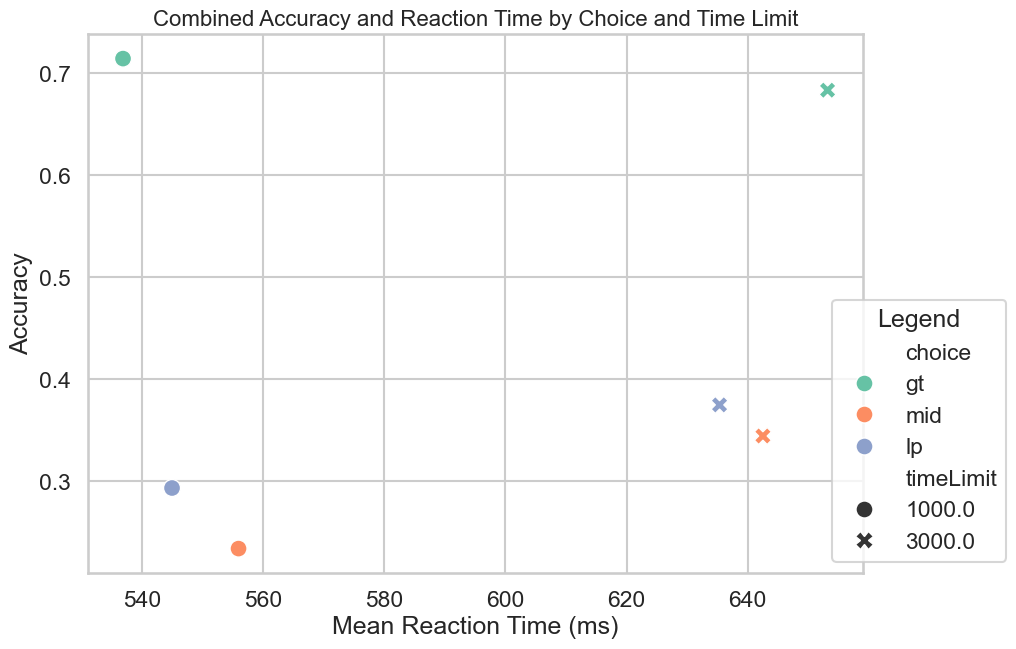

In [54]:
# Step 5: Combined Accuracy and Reaction Time Plot
def plot_combined_accuracy_rt(data):
    sns.set_theme(style="whitegrid", context="talk")

    # Calculate mean accuracy and reaction time grouped by choice and time limit
    summary = data.groupby(['choice', 'timeLimit']).agg(
        accuracy=('is_accurate', 'mean'),
        mean_rt=('rt', 'mean')
    ).reset_index()

    # Plot accuracy vs reaction time with scatter plot
    plt.figure(figsize=(10, 7))
    scatter = sns.scatterplot(
        data=summary,
        x='mean_rt',
        y='accuracy',
        hue='choice',
        style='timeLimit',
        s=150,
        palette="Set2"
    )
    scatter.set_title("Combined Accuracy and Reaction Time by Choice and Time Limit", fontsize=16)
    scatter.set_xlabel("Mean Reaction Time (ms)")
    scatter.set_ylabel("Accuracy")
    scatter.legend(title="Legend", loc='lower right', bbox_to_anchor=(1.2, 0))
    plt.show()

plot_combined_accuracy_rt(df_all)

In [ ]:
pip install bambi pymc arviz

Modeling the probability that response_numeric==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(choice), C(timeLimit), C(choice):C(timeLimit), 1|subject_id_sigma, 1|subject_id_offset, C(choice)|subject_id_sigma, C(choice)|subject_id_offset, C(timeLimit)|subject_id_sigma, C(timeLimit)|subject_id_offset, 1|stimulus_idx_sigma, 1|stimulus_idx_offset, C(choice)|stimulus_idx_sigma, C(choice)|stimulus_idx_offset, C(timeLimit)|stimulus_idx_sigma, C(timeLimit)|stimulus_idx_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


                                          mean     sd  hdi_3%  hdi_97%  \
Intercept                                0.985  0.509   0.000    1.961   
C(choice)[lp]                            0.008  0.418  -0.807    0.754   
C(choice)[mid]                           0.285  0.446  -0.525    1.159   
C(timeLimit)[3000.0]                    -0.166  0.379  -0.878    0.530   
C(choice):C(timeLimit)[lp, 3000.0]      -0.258  0.428  -1.085    0.523   
...                                        ...    ...     ...      ...   
C(timeLimit)|stimulus_idx[3000.0, 8.0]  -0.024  0.160  -0.378    0.265   
C(timeLimit)|stimulus_idx[3000.0, 9.0]  -0.015  0.163  -0.343    0.319   
C(timeLimit)|stimulus_idx[3000.0, 10.0]  0.002  0.158  -0.325    0.325   
C(timeLimit)|stimulus_idx[3000.0, 11.0] -0.055  0.172  -0.407    0.266   
C(timeLimit)|stimulus_idx[3000.0, 12.0] -0.015  0.163  -0.340    0.323   

                                         mcse_mean  mcse_sd  ess_bulk  \
Intercept                             

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'C(choice)\nlp'}>,
        <Axes: title={'center': 'C(choice)\nmid'}>,
        <Axes: title={'center': 'C(timeLimit)\n3000.0'}>],
       [<Axes: title={'center': 'C(choice):C(timeLimit)\nlp, 3000.0'}>,
        <Axes: title={'center': 'C(choice):C(timeLimit)\nmid, 3000.0'}>,
        <Axes: title={'center': '1|subject_id_sigma'}>,
        <Axes: title={'center': 'C(choice)|subject_id_sigma\nlp'}>],
       [<Axes: title={'center': 'C(choice)|subject_id_sigma\nmid'}>,
        <Axes: title={'center': 'C(timeLimit)|subject_id_sigma\n3000.0'}>,
        <Axes: title={'center': '1|stimulus_idx_sigma'}>,
        <Axes: title={'center': 'C(choice)|stimulus_idx_sigma\nlp'}>],
       [<Axes: title={'center': 'C(choice)|stimulus_idx_sigma\nmid'}>,
        <Axes: title={'center': 'C(timeLimit)|stimulus_idx_sigma\n3000.0'}>,
        <Axes: title={'center': '1|subject_id\n6651064be071e3482a85f01c'}>,
        <Axes: title={'c

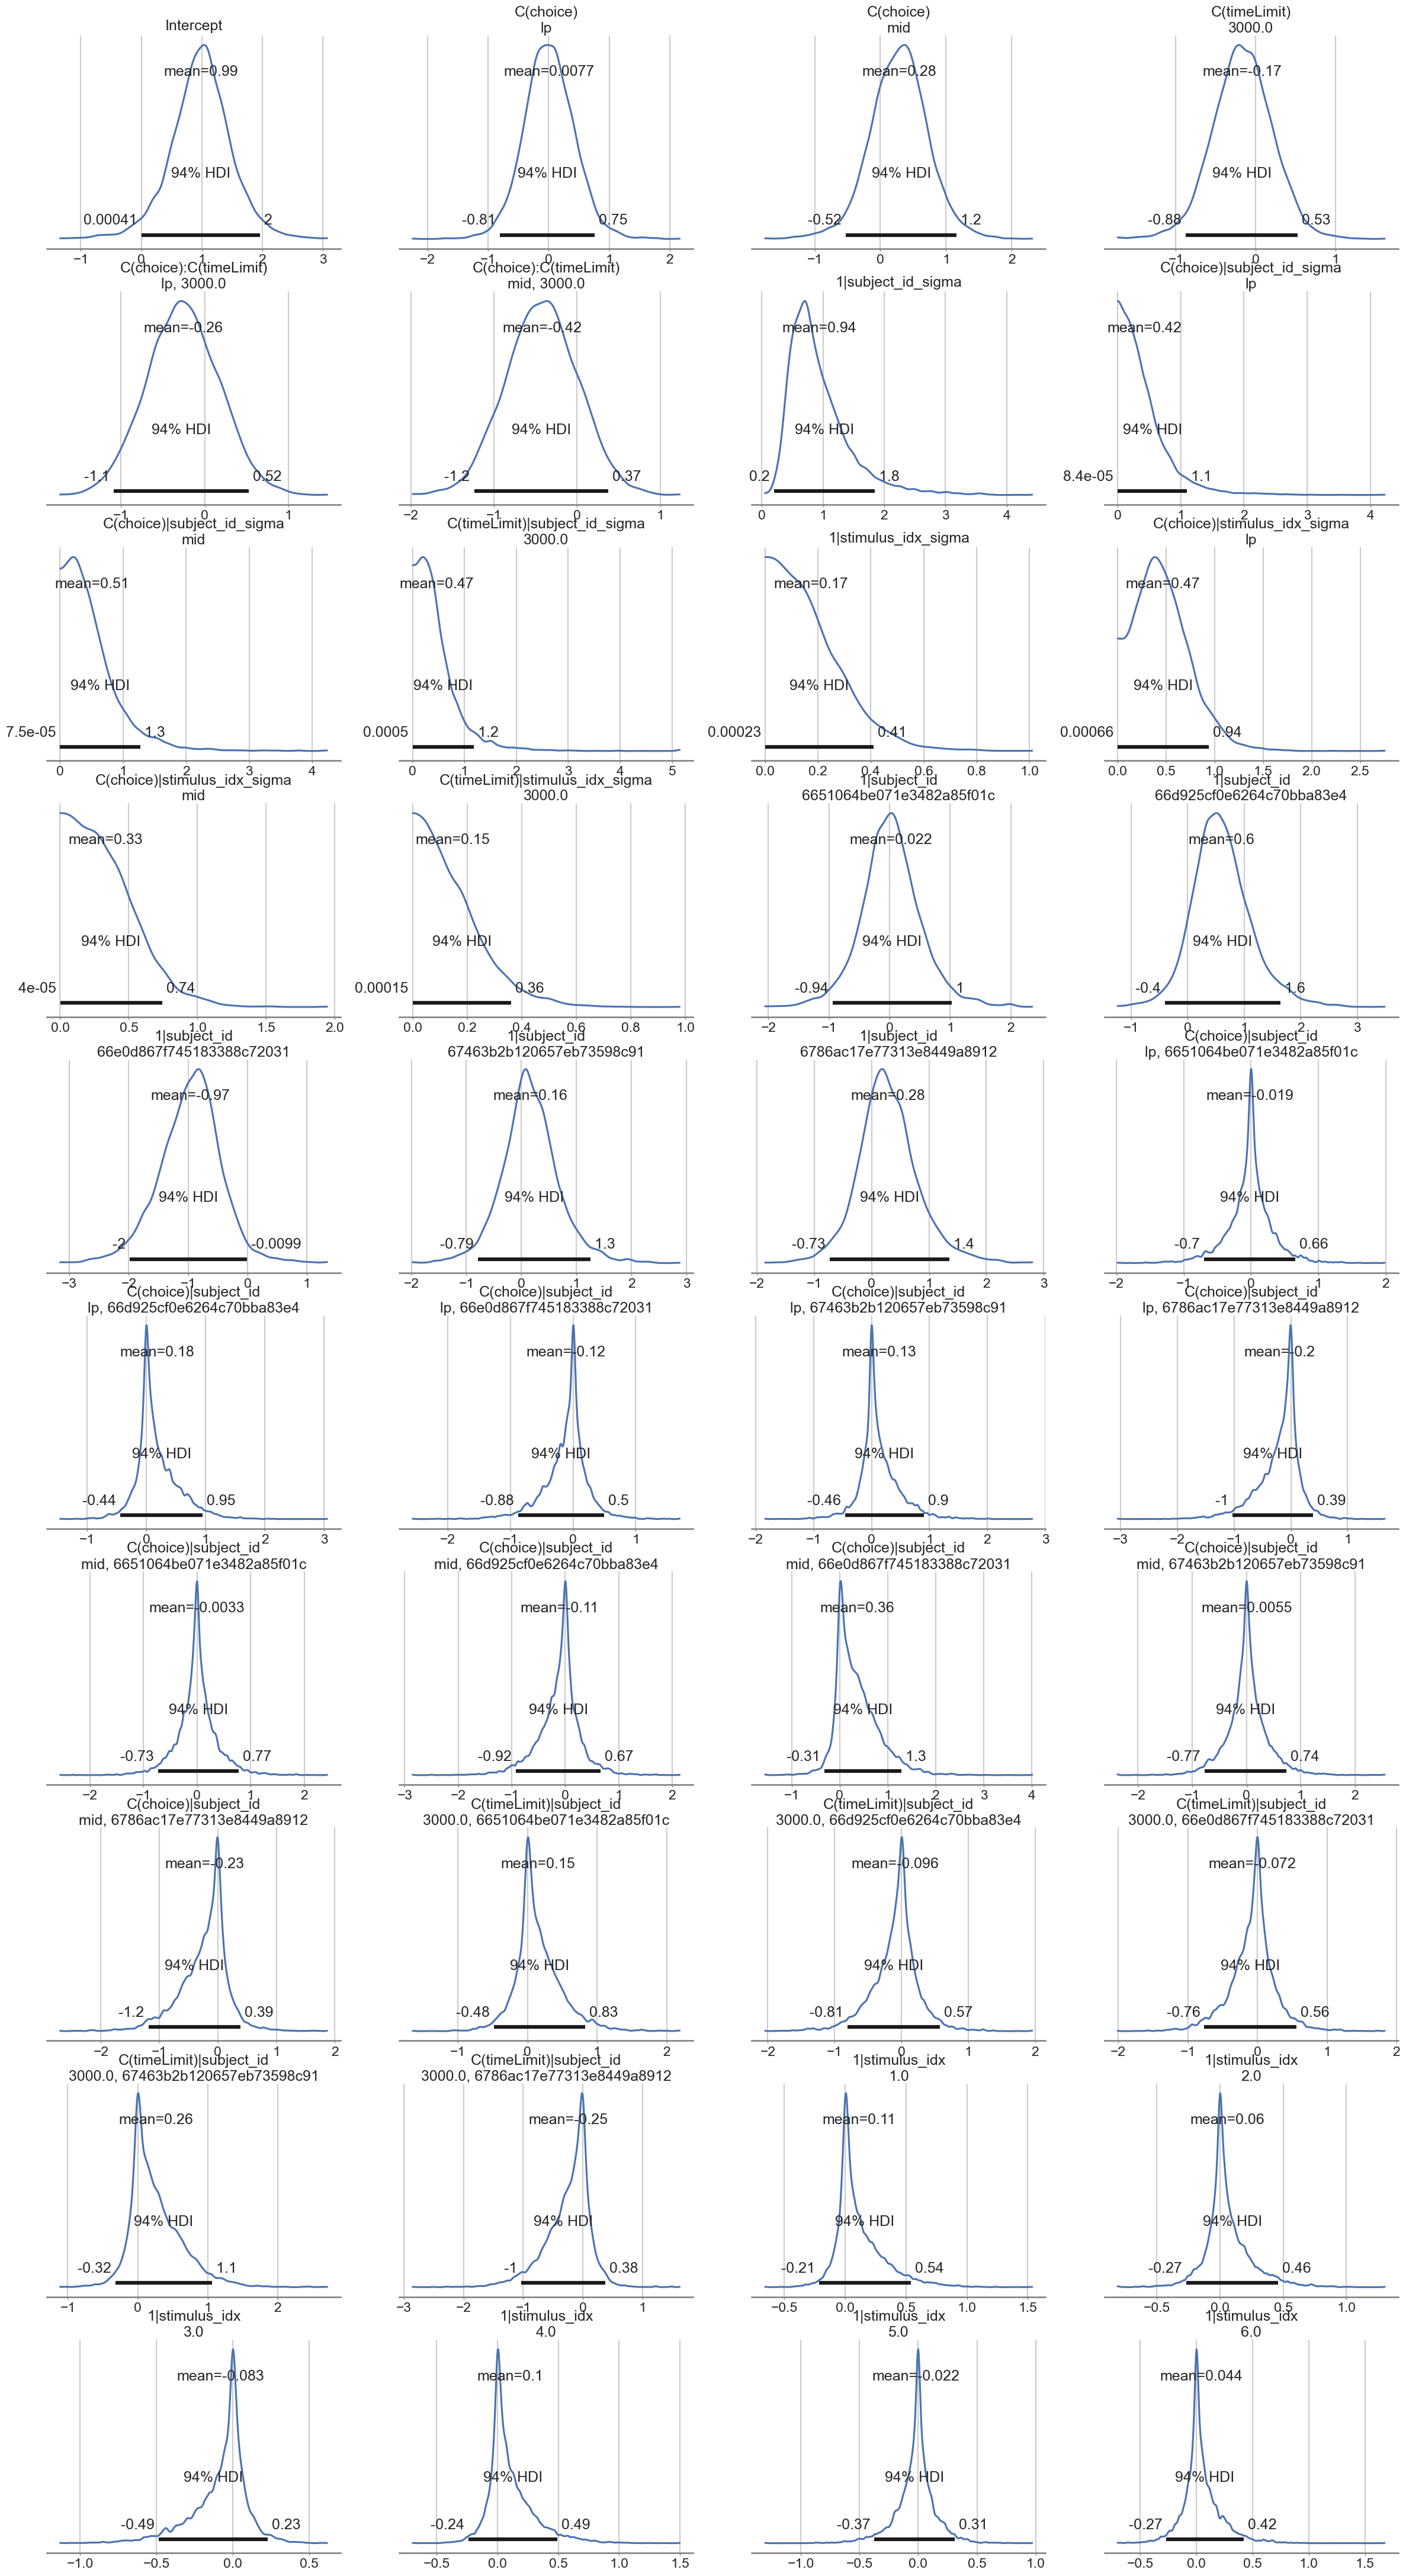

In [56]:
import bambi as bmb
import arviz as az

# Prepare the dataset
data = pd.read_csv('./df_all_pilot_v0_5participants.csv')
data = data.dropna(subset=['rt', 'response', 'choice', 'timeLimit'])

# Reverse encode response: 'j' -> 0, 'f' -> 1
data['response_numeric'] = data['response'].map({'j': 1, 'f': 0})

# Ensure categorical variables are properly handled
data['choice'] = data['choice'].astype('category')
data['subject_id'] = data['subject_id'].astype('category')
data['stimulus_idx'] = data['stimulus_idx'].astype('category')

# Specify Bayesian logistic regression with mixed effects
formula = "response_numeric ~ C(choice) * C(timeLimit) + (1 + C(choice) + C(timeLimit) | subject_id) + (1 + C(choice) + C(timeLimit) | stimulus_idx)"

# Fit the Bayesian logistic regression model
model = bmb.Model(formula, data, family="bernoulli")
results = model.fit(draws=2000, chains=4)

# Summarize the model
print(az.summary(results))

# Plot posterior distributions
az.plot_posterior(results)

In [60]:
pprint(az.summary(results)[10:20])

                                                     mean     sd  hdi_3%  \
1|stimulus_idx_sigma                                0.173  0.134   0.000   
C(choice)|stimulus_idx_sigma[lp]                    0.466  0.283   0.001   
C(choice)|stimulus_idx_sigma[mid]                   0.329  0.239   0.000   
C(timeLimit)|stimulus_idx_sigma[3000.0]             0.147  0.119   0.000   
1|subject_id[6651064be071e3482a85f01c]              0.022  0.507  -0.943   
1|subject_id[66d925cf0e6264c70bba83e4]              0.602  0.529  -0.402   
1|subject_id[66e0d867f745183388c72031]             -0.966  0.525  -1.986   
1|subject_id[67463b2b120657eb73598c91]              0.162  0.525  -0.793   
1|subject_id[6786ac17e77313e8449a8912]              0.284  0.535  -0.730   
C(choice)|subject_id[lp, 6651064be071e3482a85f01c] -0.019  0.334  -0.701   

                                                    hdi_97%  mcse_mean  \
1|stimulus_idx_sigma                                  0.411      0.002   
C(choice)|stimu

Modeling the probability that response_numeric==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(choice), C(timeLimit), C(choice):C(timeLimit), 1|subject_id_sigma, 1|subject_id_offset, C(choice)|subject_id_sigma, C(choice)|subject_id_offset, C(timeLimit)|subject_id_sigma, C(timeLimit)|subject_id_offset, 1|stimulus_idx_sigma, 1|stimulus_idx_offset, C(choice)|stimulus_idx_sigma, C(choice)|stimulus_idx_offset, C(timeLimit)|stimulus_idx_sigma, C(timeLimit)|stimulus_idx_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


                                          mean     sd  hdi_3%  hdi_97%  \
Intercept                                1.015  0.514   0.040    1.981   
C(choice)[lp]                            0.012  0.455  -0.815    0.849   
C(choice)[mid]                           0.282  0.444  -0.531    1.110   
C(timeLimit)[3000.0]                    -0.162  0.393  -0.877    0.597   
C(choice):C(timeLimit)[lp, 3000.0]      -0.254  0.429  -1.069    0.518   
...                                        ...    ...     ...      ...   
C(timeLimit)|stimulus_idx[3000.0, 8.0]  -0.023  0.163  -0.342    0.309   
C(timeLimit)|stimulus_idx[3000.0, 9.0]  -0.014  0.161  -0.371    0.291   
C(timeLimit)|stimulus_idx[3000.0, 10.0]  0.001  0.155  -0.324    0.310   
C(timeLimit)|stimulus_idx[3000.0, 11.0] -0.045  0.167  -0.424    0.233   
C(timeLimit)|stimulus_idx[3000.0, 12.0] -0.015  0.158  -0.345    0.292   

                                         mcse_mean  mcse_sd  ess_bulk  \
Intercept                             

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'C(choice)\nlp'}>,
        <Axes: title={'center': 'C(choice)\nmid'}>,
        <Axes: title={'center': 'C(timeLimit)\n3000.0'}>],
       [<Axes: title={'center': 'C(choice):C(timeLimit)\nlp, 3000.0'}>,
        <Axes: title={'center': 'C(choice):C(timeLimit)\nmid, 3000.0'}>,
        <Axes: title={'center': '1|subject_id_sigma'}>,
        <Axes: title={'center': 'C(choice)|subject_id_sigma\nlp'}>],
       [<Axes: title={'center': 'C(choice)|subject_id_sigma\nmid'}>,
        <Axes: title={'center': 'C(timeLimit)|subject_id_sigma\n3000.0'}>,
        <Axes: title={'center': '1|stimulus_idx_sigma'}>,
        <Axes: title={'center': 'C(choice)|stimulus_idx_sigma\nlp'}>],
       [<Axes: title={'center': 'C(choice)|stimulus_idx_sigma\nmid'}>,
        <Axes: title={'center': 'C(timeLimit)|stimulus_idx_sigma\n3000.0'}>,
        <Axes: title={'center': '1|subject_id\n6651064be071e3482a85f01c'}>,
        <Axes: title={'c

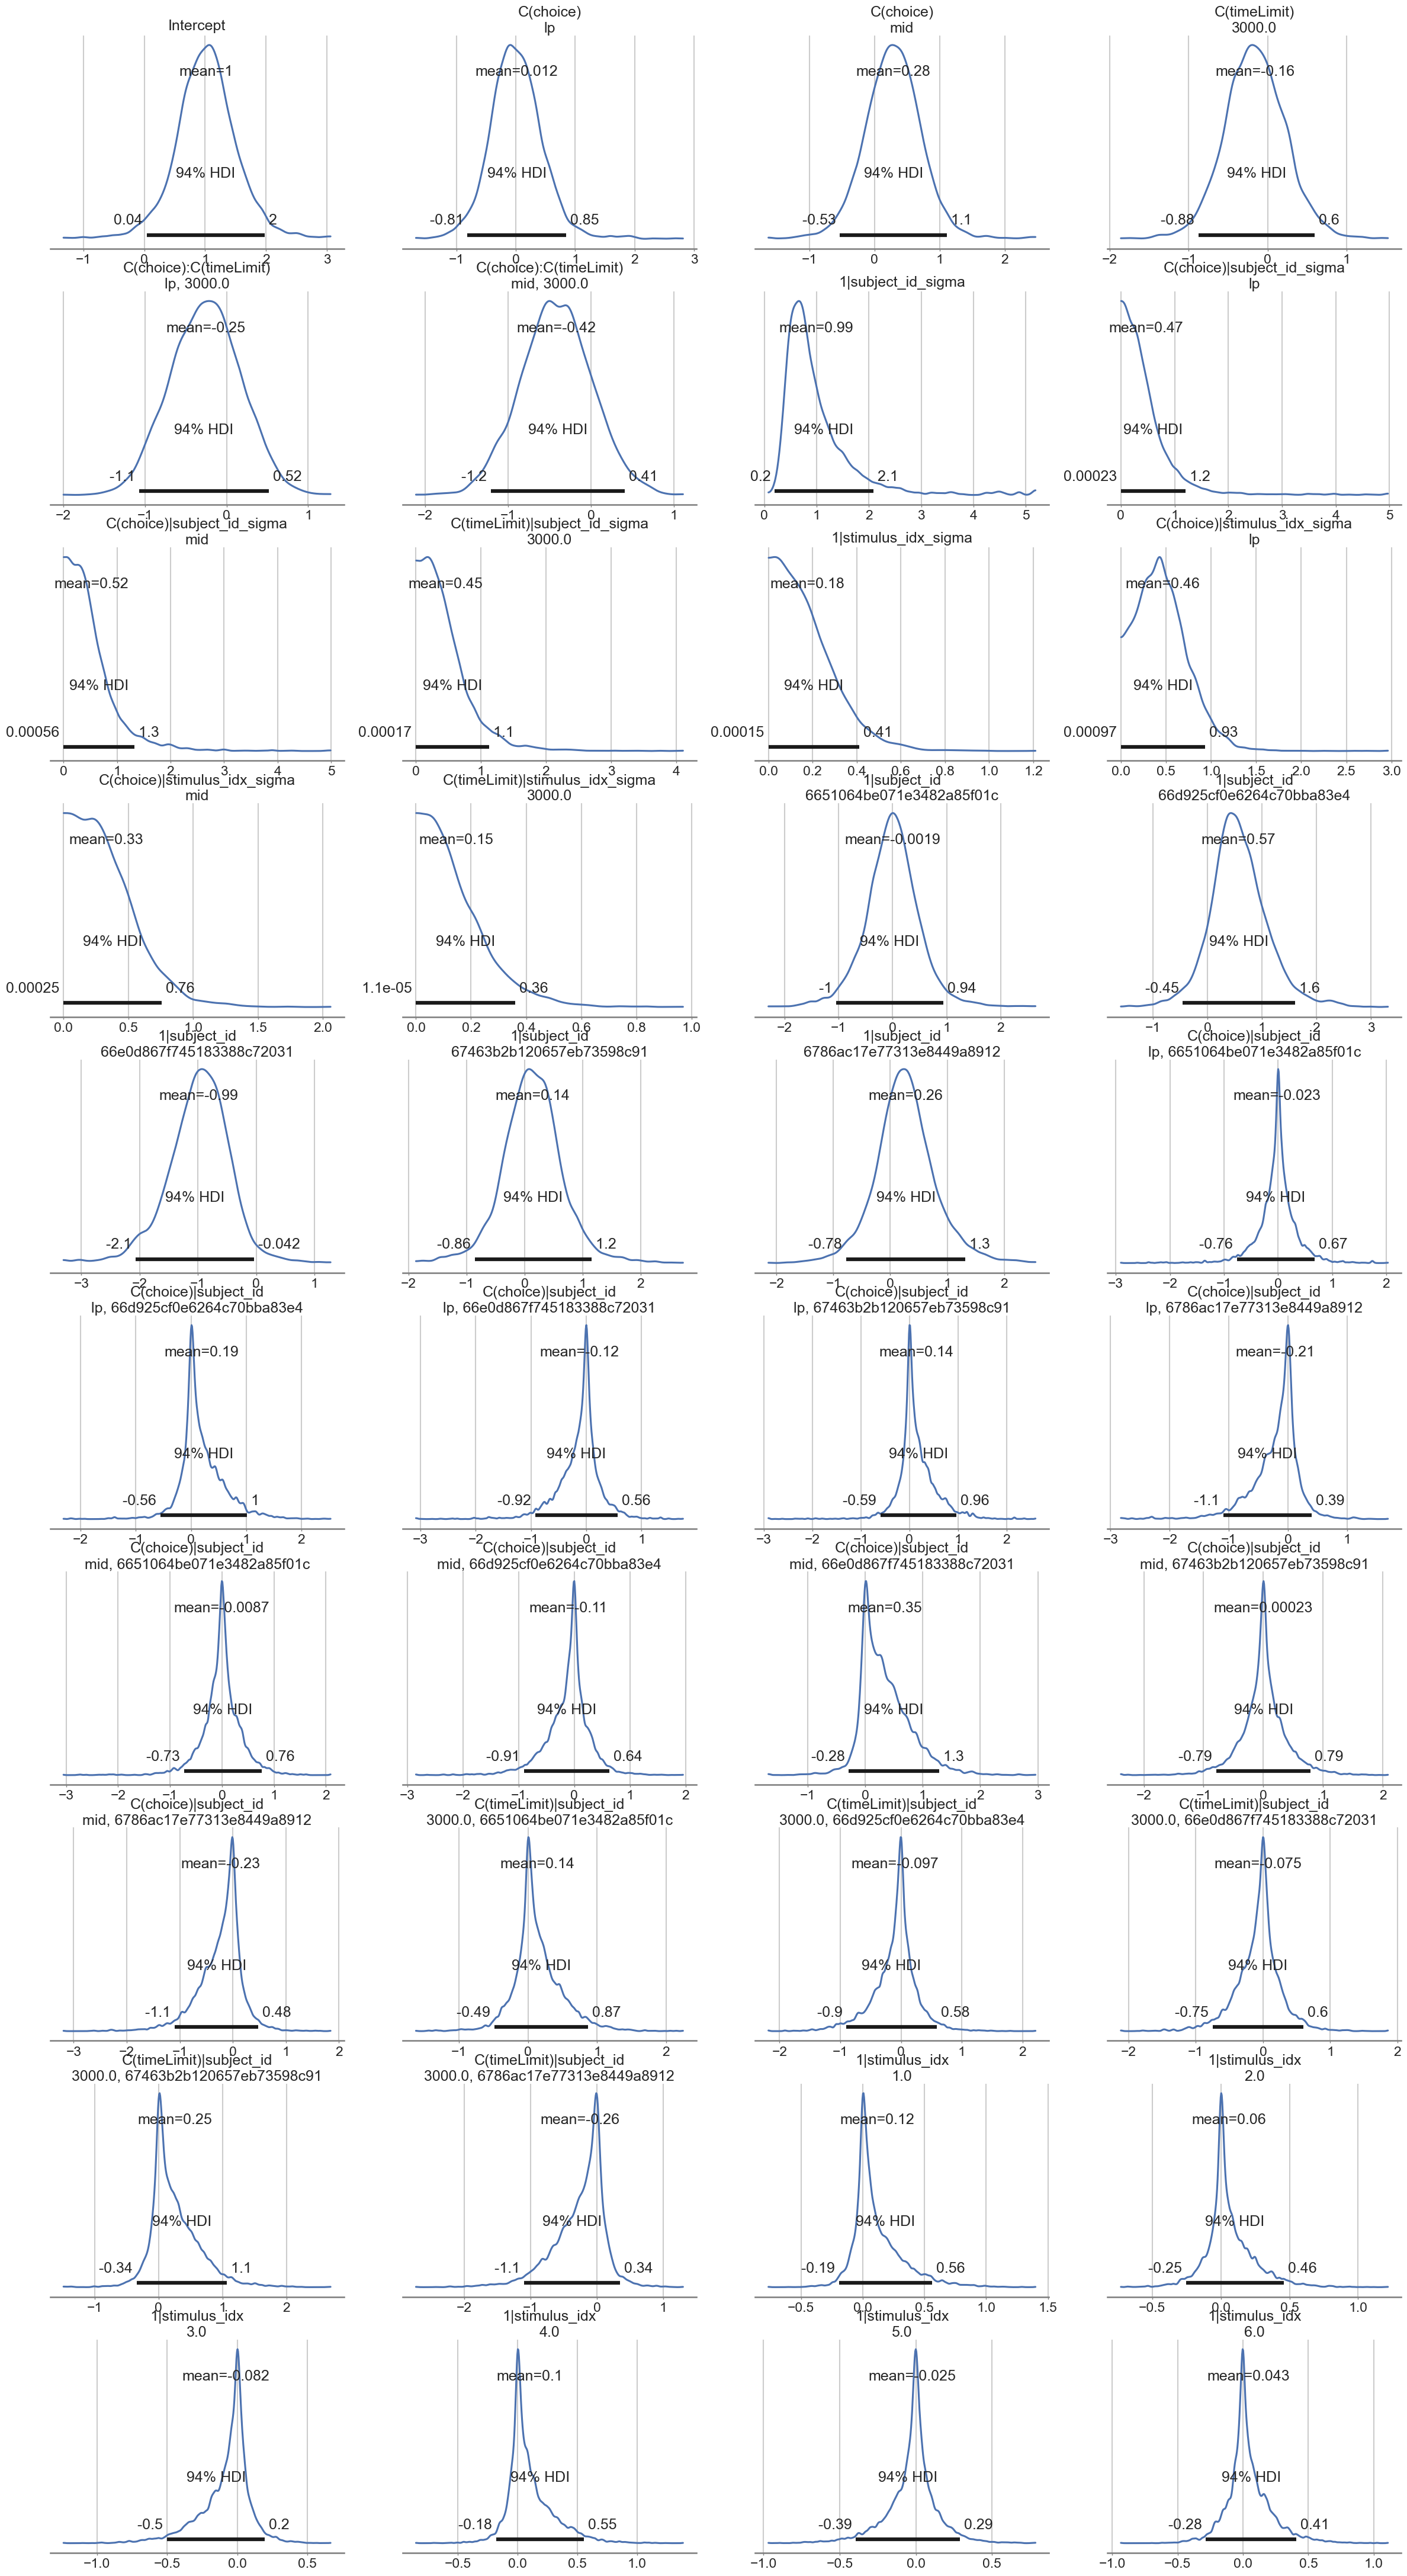

In [63]:
## a simpler model
import bambi as bmb
import arviz as az

# Specify Bayesian logistic regression with mixed effects
formula_1 = "response_numeric ~ C(choice) + C(timeLimit) + (1 | subject_id) + (1 | stimulus_idx)"

# Fit the Bayesian logistic regression model
model_1 = bmb.Model(formula_1, data, family="bernoulli")
results_1 = model.fit(draws=2000, chains=4)

# Summarize the model
print(az.summary(results_1))

# Plot posterior distributions
az.plot_posterior(results_1)

In [62]:
# Updated Visualization for Predicted Probabilities
def visualize_predicted_probabilities(model, data):
    sns.set_theme(style="whitegrid", context="talk")

    # Add predicted probabilities to the dataset
    data['predicted_prob'] = model.predict()

    # Scatter plot with colors for `choice` and shapes for `timeLimit`
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=data,
        x='choice',
        y='predicted_prob',
        hue='choice',
        style='timeLimit',
        palette="Set2",
        s=100,
        alpha=0.8
    )
    plt.title("Predicted Probabilities by Choice and Time Limit")
    plt.xlabel("Choice")
    plt.ylabel("Predicted Probability of Response 'f'")
    plt.legend(title="Legend", loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.show()

visualize_predicted_probabilities(logit_model, data)

NameError: name 'logit_model' is not defined

In [ ]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from statsmodels.formula.api import logit
import statsmodels.api as sm
# Encode response: 'j' -> 0, 'f' -> 1
df_all['response_numeric'] = df_all['response'].map({'j': 0, 'f': 1})
# Fit a zero-inflated logistic model (using Poisson as the zero-inflation assumption base)
def fit_zero_inflated_model(data):
    # Create a simplified dataset for zero-inflated modeling
    zip_data = data.copy()
    zip_data['response_numeric'] = data['response_numeric']

    # Fit the Zero-Inflated Poisson Model
    zip_model = ZeroInflatedPoisson(
        endog=zip_data['response_numeric'],
        exog=sm.add_constant(zip_data[['timeLimit']]),  # Explanatory variables
        exog_infl=sm.add_constant(zip_data[['timeLimit']]),  # Inflation model variables
    ).fit(disp=0)

    return zip_model

# Fit the model
zip_model = fit_zero_inflated_model(df_all)

# Display the model summary
print("\nZero-Inflated Logistic Model Summary:")
print(zip_model.summary())

In [ ]:
def plot_grouped_bar_rt_by_choice_time_limit(df):
    """
    Creates grouped bar plots showing RT by choice and timeLimit for accurate and inaccurate trials.
    """
    sns.set_theme(style="whitegrid", context="talk")  # Use a scientific theme

    # Filter data for accurate and inaccurate trials
    df['is_accurate'] = (
        ((df['response'] == 'j') & (df['choice'] == 'gt')) |
        ((df['response'] == 'f') & (df['choice'].isin(['lp', 'mid'])))
    )
    accurate_trials = df[df['is_accurate']]
    inaccurate_trials = df[~df['is_accurate']]

    # Group data by timeLimit and choice for both accurate and inaccurate trials
    rt_accurate = accurate_trials.groupby(['timeLimit', 'choice'])['rt'].mean().reset_index()
    rt_inaccurate = inaccurate_trials.groupby(['timeLimit', 'choice'])['rt'].mean().reset_index()

    # Create the plots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True, constrained_layout=True)

    # Accurate trials plot
    sns.barplot(data=rt_accurate, x='timeLimit', y='rt', hue='choice', ax=axs[0], palette="deep")
    axs[0].set_title('Reaction Time (RT) in Accurate Trials')
    axs[0].set_xlabel('Time Limit')
    axs[0].set_ylabel('Reaction Time (RT)')
    axs[0].legend(title='Choice')

    # Inaccurate trials plot
    sns.barplot(data=rt_inaccurate, x='timeLimit', y='rt', hue='choice', ax=axs[1], palette="muted")
    axs[1].set_title('Reaction Time (RT) in Inaccurate Trials')
    axs[1].set_xlabel('Time Limit')
    axs[1].set_ylabel('Reaction Time (RT)')
    axs[1].legend(title='Choice')

    # Show the plots
    plt.suptitle('Reaction Time by Choice and Time Limit', fontsize=20, y=1.02)
    plt.show()

# Example usage: Generate grouped bar plots for RTs in accurate and inaccurate trials
plot_grouped_bar_rt_by_choice_time_limit(processed_data)

In [ ]:
def plot_grouped_bar_accuracy_by_choice_timelimit(df):
    """
    Creates grouped bar plots showing accuracy by choice and timeLimit.
    """
    sns.set_theme(style="whitegrid", context="talk")  # Use a scientific theme

    # Group data by timeLimit and choice, calculating accuracy
    accuracy_grouped = df.groupby(['timeLimit', 'choice'])['is_accurate'].mean().reset_index()
    print(accuracy_grouped)
    # Plot accuracy grouped by timeLimit and choice
    plt.figure(figsize=(12, 6))
    sns.barplot(data=accuracy_grouped, x='timeLimit', y='is_accurate', hue='choice', palette="muted")
    plt.title('Accuracy by Choice and Time Limit')
    plt.xlabel('Time Limit')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
    plt.legend(title='Choice', loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage: Generate grouped bar plot for accuracy by choice and timeLimit
plot_grouped_bar_accuracy_by_choice_timelimit(processed_data)

In [ ]:
def plot_grouped_bar_accuracy_by_choice_timelimit(df):
    """
    Creates grouped bar plots showing accuracy by choice and timeLimit.
    """
    sns.set_theme(style="whitegrid", context="talk")  # Use a scientific theme

    # Define accuracy
    df['is_accurate'] = (
        ((df['response'] == 'j') & (df['choice'] == 'gt')) |
        ((df['response'] == 'f') & (df['choice'].isin(['lp', 'mid'])))
    )

    # Group data by timeLimit and choice, calculating accuracy
    accuracy_grouped = df.groupby(['timeLimit', 'choice'])['is_accurate'].mean().reset_index()

    # Plot accuracy grouped by timeLimit and choice
    plt.figure(figsize=(12, 6))
    sns.barplot(data=accuracy_grouped, x='timeLimit', y='is_accurate', hue='choice', palette="muted")
    plt.title('Accuracy by Choice and Time Limit')
    plt.xlabel('Time Limit')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
    plt.legend(title='Choice', loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage: Generate grouped bar plot for accuracy by choice and timeLimit
plot_grouped_bar_accuracy_by_choice_timelimit(processed_data)